In [1]:
import tensorflow as tf
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
EPOCHS = 10

## Get the data

In [3]:
train_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/"
val_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/"
test_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/"

In [4]:
train_ann = train_dir + "_annotations.coco.json"
val_ann = val_dir + "_annotations.coco.json"
test_ann = test_dir + "_annotations.coco.json"

In [5]:
train_coco = COCO(train_ann)
val_coco = COCO(val_ann)
test_coco = COCO(test_ann)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
train_size = len(train_coco.imgs)
val_size = len(val_coco.imgs)
test_size = len(test_coco.imgs)

print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)

Train size: 1502
Validation size: 429
Test size: 215


In [7]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [8]:
def get_dataset(coco, size, directory, batch_size=32):
    # Get paths and annotations
    paths = [directory + coco.imgs[i]["file_name"] for i in range(size)]
    ann_ids = coco.getAnnIds()[:size]
    anns = coco.loadAnns(ann_ids)
    
    # Create masks
    masks = np.stack([coco.annToMask(ann) for ann in anns])
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    # Create dataset
    path_dataset = tf.data.Dataset.from_tensor_slices(paths)
    image_dataset = path_dataset.map(read_image)
    mask_dataset = tf.data.Dataset.from_tensor_slices(masks)
    
    # Combine images and masks
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
    
    # Add batching and prefetching
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [9]:
train_dataset = get_dataset(train_coco, train_size, train_dir, BATCH_SIZE)
val_dataset = get_dataset(val_coco, val_size, val_dir, BATCH_SIZE)
test_dataset = get_dataset(test_coco, test_size, test_dir, BATCH_SIZE)

In [10]:
def show_dataset_samples(dataset):
    NUMBER_SAMPLES = 3
    
    # Get a single batch from the dataset
    images, masks = next(iter(dataset))
    
    # Convert to numpy for visualization
    images = images.numpy()
    masks = masks.numpy()
    
    # Create subplots
    fig, ax = plt.subplots(NUMBER_SAMPLES, 2, figsize=(10, 10))
    
    for i in range(NUMBER_SAMPLES):
        ax1, ax2 = ax[i]
        
        ax1.imshow(images[i], cmap="gray")
        ax1.set_title(f"Image {i+1}")
        ax1.axis("off")
        
        ax2.imshow(masks[i], cmap="gray")
        ax2.set_title(f"Mask {i+1}")
        ax2.axis("off")
    
    plt.show()

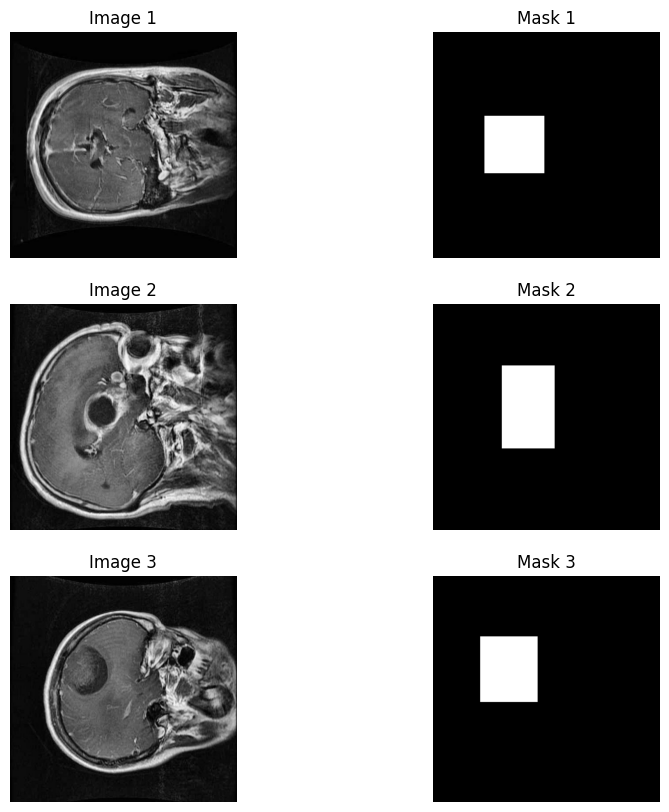

In [34]:
show_dataset_samples(train_dataset)

In [22]:
def preprocess_data(image, mask):
    image = tf.image.resize(image, (256, 256))
    mask = tf.image.resize(mask, (256, 256))
    
    # Data types
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    
    # Normalizing the input
    image = image / 255.0
    mask = tf.expand_dims(mask, axis=-1)
    return image, mask

In [23]:
train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

## U-Net Model

In [24]:
def down_block(x, n_filters, dropout_prob=0.0, want_max_pooling=True):
    """
    Convolutional downsampling block.
    
    Args:
        inputs: Input tensor.
        n_filters: Number of filters for convolutional layers.
        dropout_prob: Dropout probability.
        max_pooling: Whether to apply max pooling.

    Returns:
        next_layer: Output tensor for the next layer.
        skip_connection: Skip connection tensor.
    """
    
    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(x)
    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(out)

    if dropout_prob > 0.0:
        out = tf.keras.layers.Dropout(dropout_prob)(out)

    skip_connection = out

    if want_max_pooling:
        out = tf.keras.layers.MaxPool2D(pool_size=2)(out)

    return out, skip_connection

In [25]:
def up_block(x, skip_connection, n_filters):
    """
    Convolutional upsampling block.

    Args:
        expansive_input: Input tensor from previous layer.
        contractive_input: Skip connection tensor from encoding path.
        n_filters: Number of filters for convolutional layers.

    Returns:
        Output tensor after upsampling and convolution.
    """
    out = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer="he_normal")(x)

    #Concatenate skip connection
    out = tf.keras.layers.Concatenate()([out, skip_connection])

    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(out)
    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(out)
    return out

In [26]:
def unet_model(input_shape, n_classes, n_filters):
    """
    U-Net model implementation.

    Args:
        input_size: Shape of the input tensor.
        n_filters: Number of filters for the convolutional layers.
        n_classes: Number of output classes.

    Returns:
        U-Net model.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Down Block
    out1, skip_connection1 = down_block(inputs, n_filters)
    out2, skip_connection2 = down_block(out1, 2 * n_filters)
    out3, skip_connection3 = down_block(out2, 4 * n_filters)
    out4, skip_connection4 = down_block(out3, 8 * n_filters)
    out5, skip_connection5 = down_block(out4, 16 * n_filters, want_max_pooling=False)

    # Up Block
    up1 = up_block(out5, skip_connection4, 8 * n_filters)
    up2 = up_block(up1, skip_connection3, 4 * n_filters)
    up3 = up_block(up2, skip_connection2, 2 * n_filters)
    up4 = up_block(up3, skip_connection1, n_filters)

    outputs = tf.keras.layers.Conv2D(filters=n_classes, kernel_size=1, activation="sigmoid", padding="same")(up4)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
# Getting dimensions of the input image
width = None
height = None
n_channels = None
for image, mask in train_dataset.take(1):
    _, w, h, c = image.shape
    width, height, n_channels = w, h, c

In [28]:
input_shape = (width, height, n_channels)
print(input_shape)

(256, 256, 3)


In [29]:
n_classes = 1
n_filters = 32
model = unet_model(input_shape, n_classes, n_filters)

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 128)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 256)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 256)    │      1,179,904 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 8,630,497 (32.92 MB)

 Trainable params: 8,630,497 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
optimizer = tf.keras.optimizers.Adam(1e-2)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metrics,
)

In [32]:
model.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8751 - loss: 1627677.8750 - val_accuracy: 0.9626 - val_loss: 0.1785
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.9621 - loss: 0.1835 - val_accuracy: 0.9626 - val_loss: 0.1763
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.9621 - loss: 0.1508 - val_accuracy: 0.9626 - val_loss: 0.1950
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.9613 - loss: 0.2010 - val_accuracy: 0.9626 - val_loss: 0.2089
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.9621 - loss: 0.2045 - val_accuracy: 0.9626 - val_loss: 0.1575
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.9621 - loss: 0.1589 - val_accuracy: 0.9626 - val_loss: 0.1572
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.9621 - loss: 0.1589 - val_accuracy: 0.9626 - val_loss: 0.1572
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.9621 - loss: 0.1589 - val_a

In [34]:
history = model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9605 - loss: 0.1641  


In [57]:
import random
def visualize_results(model, dataset, num_samples=5, threshold=0.5):
    # Select a random batch
    random_batch = random.choice(list(dataset))
    images, masks = random_batch

    # Select random indices for num_samples
    iterations = min(len(images), num_samples)

    predictions = model.predict(images)

    # Binarizing prediction masks
    binary_predictions = (predictions > threshold).astype('uint8')

    for i in range(iterations):
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i] * 255) # Undo normalization to see the image
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


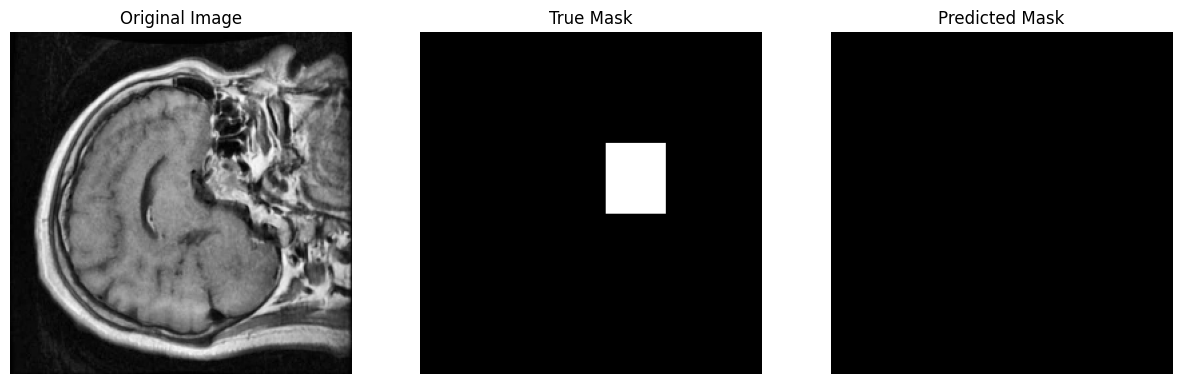

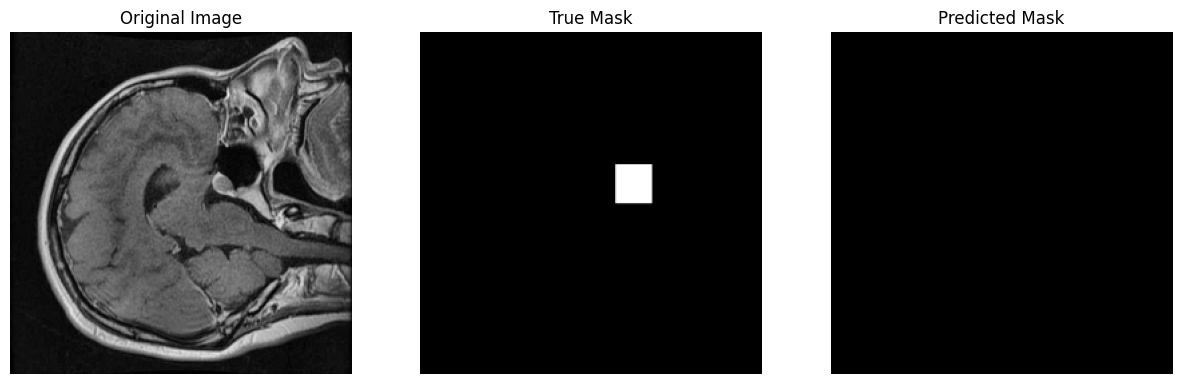

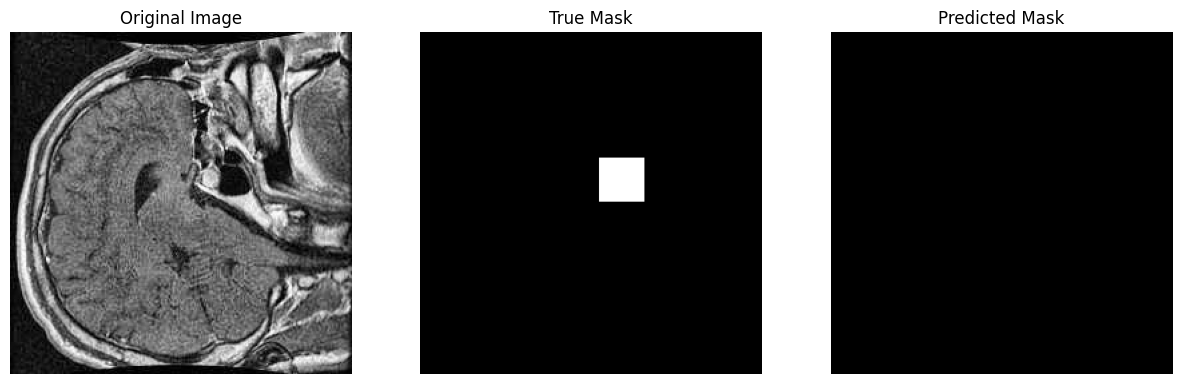

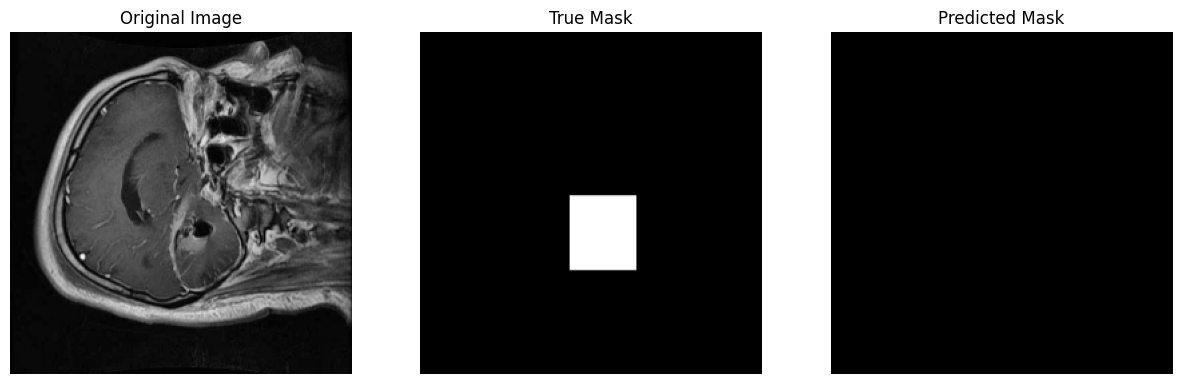

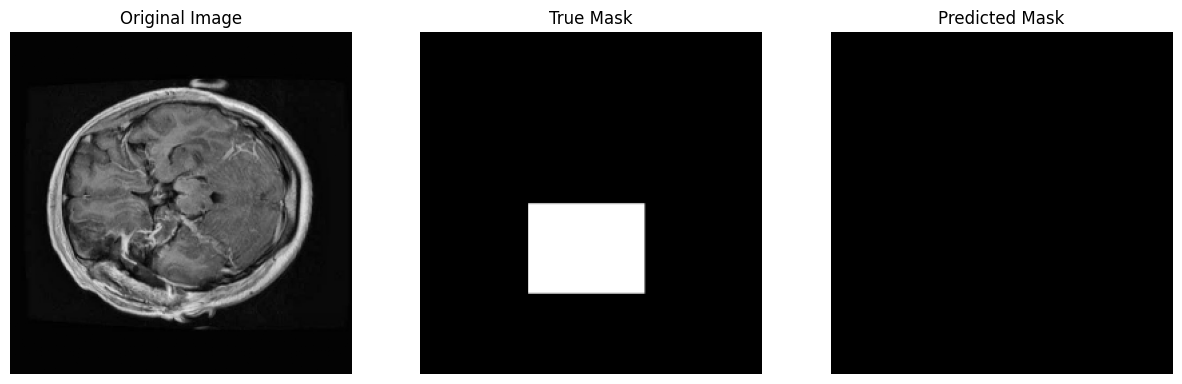

In [58]:
visualize_results(model, test_dataset, 5)